#### Terminology point:

This project relies quite a bit on how names are categorized by the Social Security Administration. Each birth is registered as either male or female, and throughout the text, these terms refer to that assigned sex.

In [1]:
#It's been talked about so often times that it's hard to find an 
#original source, but the idea of "unique but familiar" is all
#over in marketing. Probably the most famous version is "Most
#Advanced Yet Acceptable", coined by Raymond Loewy. Basically,
#people like things that are new, but fit somewhere they know.

#For this project, my goal is to help users find names that "fit".
#If a name 1) feels familiar, and 2) tells you immediately that 
#the named person is from a specific time period or age range, 
#that's what I'm going for. Familiar, but unique enough to tell 
#you useful information about the person's age or the year. 

#Say you want to market something to people around 65. Do you
#want to pick "Jacob" as a name in an ad? Probably not. The 
#vast majority of people named "Jacob" are under 40. What if
#you wanted to have a believable name for someone 20-30 in a
#period piece set in 1990? You really don't want "Cayden", 
#that much you probably know, but how do we figure out who

#"Most Advanced Yet Acceptable"
#https://www.theatlantic.com/magazine/archive/2017/01/what-makes-things-cool/508772/

In [2]:
%config Completer.use_jedi = False
#Autocomplete has been finicky, switching versions. 

In [3]:
import numpy as np
import pandas as pd
import csv
import os
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import colorsys
from wordcloud import WordCloud

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import datetime as dt
import pickle


In [4]:
#Set figure options:

#Yes, I want this as a universal default across all notebooks.
matplotlib.rcParams['font.sans-serif'] = ['Helvetica']

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
# plt.rc('legend', fontsize=12)    # legend fontsize
# plt.rc('figure', titlesize=10)  # fontsize of the figure title

In [9]:
#Load preprocessed data generated in "Names_calculate_reduced"
#or in prior actuarial estimations.

#From actuarial (small files):
alive_F = pd.read_pickle('life_F_df.pkl')
alive_M = pd.read_pickle('life_M_df.pkl')
alive_F_p = pd.read_pickle('life_F_p_df.pkl')
alive_M_p = pd.read_pickle('life_M_p_df.pkl')

#From 'Names_calculate_reduced':

#Total births, from SSA:
totalnames_table = pd.read_pickle('Total_soc_cards.pkl')

# #Names dataframe, HANDLED BELOW
# names_df = pd.read_pickle('names_df.pkl')
# names_df_trim = pd.read_pickle('names_df.pkl')

#Year of birth data:
namelife_M_yob = np.load('namelife_M_yob.npy')
namelife_F_yob = np.load('namelife_F_yob.npy')
#"Base" life data (total of all ages alive each year):
namelife_M_base = np.load('namelife_M_base.npy')
namelife_F_base = np.load('namelife_F_base.npy')
#"Name" data: the names associated with the others
namelife_M_name = np.load('namelife_M_name.npy', allow_pickle=True)
namelife_F_name = np.load('namelife_F_name.npy', allow_pickle=True)


#Calculated properties of the characteristic name sets:
sel_specif_F = np.load('sel_specif_F140.npy')
sel_weight_F = np.load('sel_weight_F140.npy')
sel_scores_F = np.load('sel_scores_F140.npy')
sel_ages_F = np.load('sel_ages_F140.npy')
sel_names_F = np.load('sel_names_F140.npy', allow_pickle=True)

sel_specif_M = np.load('sel_specif_M140.npy')
sel_weight_M = np.load('sel_weight_M140.npy')
sel_scores_M = np.load('sel_scores_M140.npy')
sel_ages_M = np.load('sel_ages_M140.npy')
sel_names_M = np.load('sel_names_M140.npy', allow_pickle=True)




In [10]:
#Load the year-of-birth data, in "yobYYYY.txt" format csv files.
#
#Data source: https://www.ssa.gov/OACT/babynames/limits.html,
#manual download of national zip file that unpacks to the files
#below.

#REFRESH EVERY TIME. The data structures take up just over 100MB,
#so they do not play nice with Github. Takes under 30 seconds.

refresh = True

if refresh:

    #Drop down into the correct directory,
    os.chdir('../Names/names_w2020')
    #grab a list of the files in it,
    current_dir = os.listdir()

    names_temp = []
    #step through them, loading and appending
    for ftemp in current_dir:
        if ftemp[-3:] == 'txt':
            dftemp = pd.read_csv(ftemp, names=['Name','Sex','Number'])
            dftemp['Year'] = int(ftemp[3:-4])
            names_temp.append(dftemp)

    #chop them all together
    names_df = pd.concat(names_temp)
    names_df.info()

    #go back up
    os.chdir('..')


    #Reset the indexes to unduplicate them, since each stack was indexed 
    #separately; keeping the old indices is handy though, so default
    #'drop = false' option is kept.

    #Yes, the sorting matters. It makes plotting way easier later on, and
    #I could definitely use it to speed up the name structure indexing. 

    names_df = names_df.reset_index().sort_values(['Name','Year'])



    #"names_df" is raw, not controlled for population or births. What was 
    #the total as a fraction of the year's name births? Currently only
    #using the total names included in this data as the core comparison.
    #Could pull from the social security total above in future changes.

    year_total = names_df.groupby('Year').sum()

    #Join year_total w/ names_df to get what fraction of named births
    #that year made up of the given name/sex pair:
    names_df = pd.merge(left=names_df, right=totalnames_table, 
                        left_on='Year', right_on='Year of birth', 
                        how='left')
    names_df['Fraction'] = names_df['Number']/names_df['Total']

    #Not normalizing to separate male or female births, only total.
    #Possibly another future improvement, since the likelihood of 
    #registering males/females appears to have been biased early on. 
    names_df.drop(columns=['Male','Female','Total'], inplace=True)

    #Calculate total number of births for each name:
    totalbirths_byname = names_df[['Name','Sex','Number']].groupby(['Name','Sex']).sum()

    trimvalue = 20
    #Limit dataset to names that had more than 20 total births
    #with that name:
    keepnames = totalbirths_byname[totalbirths_byname['Number'] > trimvalue]

    #Join on name/sex pairs to keep only ones included above
    names_df_trim = pd.merge(left=names_df, right=keepnames, on=['Name','Sex'], how='inner')
    #Handling number column ambiguity, not pretty but works fine
    names_df_trim['Number'] = names_df_trim['Number_x']
    names_df_trim.drop(columns=['Number_x', 'Number_y'], inplace=True)
    val1 = len(names_df.groupby(['Name','Sex']).size())
    val2 = len(names_df_trim.groupby(['Name','Sex']).size())
    val1a = len(names_df)
    val2a = len(names_df_trim)

    #Display results
    print('Pretrim -> posttrim, minimum {} births:\n'.format(trimvalue))
    print('Names (total M/F separately):')
    print(val1, '->', val2)
    print('Name/year records:')
    print(val1a, '->', val2a)
    print('\nRemoves {:.2f} of names while only removing {:.3f} of total birth records.'.format((val1-val2)/val1, (val1a-val2a)/val1a))

    #names_df.to_pickle('names_df.pkl')
    #names_df_trim.to_pickle('names_df_trim.pkl')
    
else:
    names_df = pd.read_pickle('names_df.pkl')
    names_df_trim = pd.read_pickle('names_df.pkl')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2020863 entries, 0 to 32029
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Name    object
 1   Sex     object
 2   Number  int64 
 3   Year    int64 
dtypes: int64(2), object(2)
memory usage: 77.1+ MB
Pretrim -> posttrim, minimum 20 births:

Names (total M/F separately):
111472 -> 70589
Name/year records:
2020863 -> 1956469

Removes 0.37 of names while only removing 0.032 of total birth records.


In [11]:
#Reprocessing actuarial data to estimate pre-1900 lives:

#Assume 1880-1900 lifespans have the same trajectory as 1900, then 
#normalize the starting births to match the number from that cohort
#who were alive in 1900. We can get that data from the period life
#tables; they predict how long someone will live based on how many
#people who are X age in the previous year are still alive.

alive_F_prescale = alive_F.copy() #Keep originals for reference
alive_M_prescale = alive_M.copy() #Keep originals for reference

#Add rows for 1880-1899:

#Could avoid loop, but it's fast anyway.
for year in np.arange(1880, 1900):
    alive_F.loc[year,:] = alive_F.loc[1900,:]
    alive_F_prescale.loc[year,:] = alive_F_prescale.loc[1900,:]
    #Multiply that year's aliveness vector by a scale number that
    #makes the aliveness in 1900 line up with the "p" (period)
    #data for 1900, which is based on past survival.
    alive_F.loc[year,:] = alive_F.loc[year,:] * (alive_F_p.loc[1900,1900-year-1])/(alive_F.loc[1900,1900-year-1])
alive_F = alive_F.sort_index()
alive_F_prescale = alive_F_prescale.sort_index()

for year in np.arange(1880, 1900):
    alive_M.loc[year,:] = alive_M.loc[1900,:]
    alive_M_prescale.loc[year,:] = alive_M_prescale.loc[1900,:]
    alive_M.loc[year,:] = alive_M.loc[year,:] * (alive_M_p.loc[1900,1900-year-1])/(alive_M.loc[1900,1900-year-1])
alive_M = alive_M.sort_index()
alive_M_prescale = alive_M_prescale.sort_index()

#In short, the alive_X structures are the number of people born in [row]
#year that have/will survive for [col] years. I'm using this "cohort data" 
#rather than period data, since I'm most interested in tracking individual
#lives across the timespan. THIS WILL MEAN THAT THE LIFE TABLE DOES NOT
#START AT 100,000 FOR THESE VALUES. That won't cause any analysis problems, 
#but should be kept in mind because it's nonstandard for actuarial data.

In [12]:
# #Takes well under 1 minute now.

# #Average life-weighted year-of birth for each name for each year

# #DOES NOT CHECK WHETHER ANYONE IS STILL ALIVE IN X YEAR BEFORE 
# #DOING MATH, SO EXPECT DIVIDE BY ZERO ERRORS. NaNs are fine for
# #showing lack of people alive, but it's not pretty.

# #It is possible to do this with matrix multiplication. It would
# #take way longer to get organized right than just running it. 

# agevec = np.arange(1880,1880+nyears).T

# aliveshape = namelife_M_full.shape
# namelife_M_yob = np.zeros(namelife_M_base.shape)
# namelife_sum = np.sum(namelife_M_full, axis=1)
# for rowind in np.arange(0,aliveshape[0]):
#     tempsum = namelife_sum[rowind,:]
#     namelife_M_yob[rowind,:] = np.matmul(agevec, namelife_M_full[rowind,:,:]) / \
#                                namelife_sum[rowind,:]

# aliveshape = namelife_F_full.shape
# namelife_F_yob = np.zeros(namelife_F_base.shape)
# namelife_sum = np.sum(namelife_F_full, axis=1)
# for rowind in np.arange(0,aliveshape[0]):
#     namelife_F_yob[rowind,:] = np.matmul(agevec, namelife_F_full[rowind,:,:]) / \
#                                 namelife_sum[rowind,:]

In [13]:
#General notes:

#This would be a good place in the future to normalize by ESTIMATED
#births in a given birth year. It's reasonable to only use SSA-named
#births, but it's more likely to represent the population well if I
#scale name-set births up by the ratio of estimated total births to
#recorded births.

#How to do that: Calculate estimated births each year 1880+, multiply
#pop of each name from that year by the ratio of estimated births to
#names dataset births. 
#Options for calculating estimated births:
#    -Derive number of births from the census (feasible)
#    -Take the number of people alive of a given age, then scale the 
#     names alive to match (would be inaccurate due to immigration)


#Future potential comparisons:

#Stacked line plot of all high-count names (i.e. with >10,000 holders),
#with color of the swath for that name varying w/ avg age at the x-axis
#time. Large plot!

#Geographic names (cities, states, rivers?)
#Names and abbreviations (Lawrence and Larry, Christopher and Chris, 
#Robert and Bob/Rob, Richard and Rick/Dick, Harold and Harry, Thomas
#and Tom/Thom, etc.

In [15]:
#USER INPUTS: 

#"Target year", entry box
# -Target year (i.e. 1960)

#"Year range", dropdown menu, options based on Target Year
# -Year range, +-0, +-2, +-5 (i.e. 1960, 1958-1962, 1955-1965)

#"Target age", entry box, will max/min based on Target Year
# -Target age (i.e. 20)

#"Age range", dropdown menu, options based on Target Age
# -Age range, +-2 or +-5 (i.e. 18-22, 15-25)

#"Sex", dropdown menu
# -Sex (M or F)

# Begin visualization code

Below is the current visualization code. I am in the progress of optimizing this to work from a derived set of data, rather than calculating the full characteristic values for every name at every call. Currently, it uses a pair of matrices around (25000 | 40000) x 140 x 180 (~25k rows for male names, 40k rows for female names) which is a lot, but it could get by on the set of names/properties for each potential window and potential age. If I constrain the windows for year and age range to either 5 or 10 years and only save the top 100 names, then it's a (135+130) x (135+130) x 100 matrix for M and F each, cutting it down from >1 billion elements to ~15 million. 

From the user perspective, that would look like the user selecting a single year and a single age, then whether to use a window of 5 or 10 years around either.

In [16]:
#Goal colors: Plotly defaults, #EF553B (red), #636EFA (blue):
#https://www.rapidtables.com/convert/color/rgb-to-hsv.html
#HSV, red: 9deg, 75.3%, 93.7%
#HSV, blue: 236deg, 60.4%, 98.0%

In [17]:
#Convenience function to plot births for a given name

def showname(name, sex):
    subdf = names_df_trim[(names_df_trim['Name']==name) & (names_df_trim['Sex']==sex)]
    plt.figure(figsize=[14,4])
    plt.bar(subdf['Year'],subdf['Number'])
    plt.xlim([1880,2020])
    plt.title(f'Number of {name} ({sex}) born per year')
    plt.show()

In [40]:
#Primary data visualization function: GENERATE VALUES AND CALL VIS FUNCTION(S)

def get_era_names(year, yearrange,
                  age, agerange,
                  sex,
                  n_names=25):
    """
    This function selects and rewraps data from the targeted year/age range
    to pass to the visualization functions. 
    
    'yearrange' options: [0, 4, 10] (year:year+1, year:year+5, year:year+11)
    'agerange' options: [4, 10] (age:age+5, age:age+11)
    
    These sets of options are symmetrical, can be centered around target
    rather than starting with target in future iterations. 
    
    Example input: 1990, 4, 20, 4
    Resulting tgt: years 1990-1994 (inclusive), ages 20-24 (inclusive)
    
    This target is then used to pull the matched preprocessed outputs from
    "sel_" datastructures, which are fed into the display function(s). 
    """
    
    
    # displayfunc=display_sparklines   

    inds = [year - 1880, age, [0,4,10].index(yearrange), [4,10].index(agerange)]

    if sex=="F":
        s_specif = sel_specif_F[inds[0],inds[1],inds[2],inds[3],:]
        s_weight = sel_weight_F[inds[0],inds[1],inds[2],inds[3],:]
        s_scores = sel_scores_F[inds[0],inds[1],inds[2],inds[3],:]
        s_ages = sel_ages_F[inds[0],inds[1],inds[2],inds[3],:]
        s_names = sel_names_F[inds[0],inds[1],inds[2],inds[3],:]
    elif sex=="M":
        s_specif = sel_specif_M[inds[0],inds[1],inds[2],inds[3],:]
        s_weight = sel_weight_M[inds[0],inds[1],inds[2],inds[3],:]
        s_scores = sel_scores_M[inds[0],inds[1],inds[2],inds[3],:]
        s_ages = sel_ages_M[inds[0],inds[1],inds[2],inds[3],:]
        s_names = sel_names_M[inds[0],inds[1],inds[2],inds[3],:]


    sizedict = {}
    coldict = {}
    for n in range(n_names):
        dictkey = s_names[-(n+1)]
        sizedict[dictkey] = int(s_weight[-(n+1)] * 100)
        coldict[dictkey] = s_scores[-(n+1)] 

    namerange_data = (s_specif, s_weight, s_scores, s_ages, s_names)
    
    #Visualization subfunction: WORDCLOUD  
    display_namecloud(sizedict, coldict, sex)

    #Visualization subfunction: SPARKLINES
    out_lines = display_sparklines(namerange_data, target_range, n_names=n_names)
    
    return namerange_data

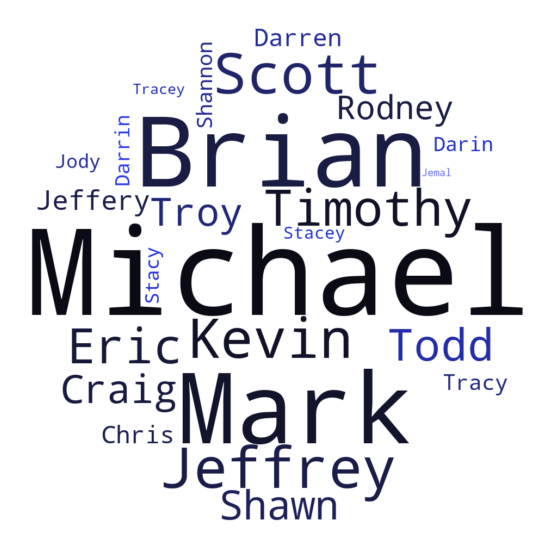

In [86]:
year = 1990
yearrange = 4
age = 20
agerange = 4
sex = 'M'
n_names=25
 

inds = [year - 1880, age, [0,4,10].index(yearrange), [4,10].index(agerange)]

if sex=="F":
    s_specif = sel_specif_F[inds[0],inds[1],inds[2],inds[3],:]
    s_weight = sel_weight_F[inds[0],inds[1],inds[2],inds[3],:]
    s_scores = sel_scores_F[inds[0],inds[1],inds[2],inds[3],:]
    s_ages = sel_ages_F[inds[0],inds[1],inds[2],inds[3],:]
    s_names = sel_names_F[inds[0],inds[1],inds[2],inds[3],:]
elif sex=="M":
    s_specif = sel_specif_M[inds[0],inds[1],inds[2],inds[3],:]
    s_weight = sel_weight_M[inds[0],inds[1],inds[2],inds[3],:]
    s_scores = sel_scores_M[inds[0],inds[1],inds[2],inds[3],:]
    s_ages = sel_ages_M[inds[0],inds[1],inds[2],inds[3],:]
    s_names = sel_names_M[inds[0],inds[1],inds[2],inds[3],:]


sizedict = {}
coldict = {}
for n in range(n_names):
    dictkey = s_names[-(n+1)]
    sizedict[dictkey] = int(np.sqrt(s_weight[-(n+1)]))
    coldict[dictkey] = np.sqrt(s_specif[-(n+1)])

namerange_data = (s_specif, s_weight, s_scores, s_ages, s_names)

display_namecloud(sizedict, coldict, sex)
disp

In [83]:
#Primary data visualization function: WORD CLOUD

def display_namecloud(sizedict, coldict, sex):

    #DISPLAY:
    #TODO: Use viridis_r for individual-name age colormap

    #Make a circle mask
    cscale = 1000
    x, y = np.ogrid[:cscale, :cscale]
    mask = (x - cscale/2) ** 2 + (y - cscale/2) ** 2 > (cscale/2-20) ** 2
    mask = 255 * mask.astype(int)

    built_cloud = WordCloud(background_color='white',
                            repeat=False, 
                            width=800, 
                            height=500,
                            max_font_size=250,
                            mask=mask)

    wcloud = built_cloud.generate_from_frequencies(sizedict)

    fig, ax = plt.subplots(1,1, figsize=[10,10])
    ax.axis('off')
    #plt.imshow(wcloud, interpolation='bilinear')
    #plt.show()

    if sex=='F':
        hueval = 4
    else:
        hueval = 236

    #Alternative color pulled from:
    #https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html
    #Also adapted from:
    #https://stackoverflow.com/questions/47143461/python-wordcloud-color-by-term-frequency

    #CONSIDER ALTERNATIVE:
    # colorsys.rgb_to_hls(200/255,100/255,200/255)

    #[120,360]
    #     hue_lim = [100,260] #cyan to magenta, through blue. Mean 240, full blue.
    #     sat_lim = [100,0]
    #     lit_lim = [80,0]
    hue_lim = [260,100] #cyan to magenta, through blue. Mean 240, full blue.
    sat_lim = [30,100]
    lit_lim = [0,80]
    col_lim = [min(coldict.values())*.9, max(coldict.values())*1.1]
    def hue_scaler(num):
        #Simple linear transformation converts color from (n1)-5:(n2)+5 range to hsl_lim range
        tgt_hue = hue_lim[0] + (num - col_lim[0])*(hue_lim[1] - hue_lim[0]) / (col_lim[1] - col_lim[0])
        return tgt_hue
    def sat_scaler(num):
        #Scale from desat at old to colorful at young
        tgt_sat = sat_lim[0] + (num - col_lim[0])*(sat_lim[1] - sat_lim[0]) / (col_lim[1] - col_lim[0])
        #Scale saturation from middle (use 100,-100 for ex):
        #         if tgt_sat < (sat_lim[1] + sat_lim[0])/2:
        #             tgt_sat = sat_lim[1] - tgt_sat
        return min([100,max([tgt_sat,0])])
    def lit_scaler(num):
        tgt_lit = lit_lim[0] + (num - col_lim[0])*(lit_lim[1] - lit_lim[0]) / (col_lim[1] - col_lim[0])
        return min([100,max([tgt_lit,0])])

    def color_func(coldictionary):
        def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
            temphue = hue_scaler(coldictionary[word])
            tempsat = sat_scaler(coldictionary[word])
            templit = lit_scaler(coldictionary[word])
            return f"hsl({hueval}, {tempsat:.0f}%, {templit:.0f}%)"
        return my_tf_color_func_inner

    plt.imshow(wcloud.recolor(color_func=color_func(coldict), random_state=3),
           interpolation="bilinear")
    plt.show()

In [ ]:
#Primary data visualization function: SPARK(like) TREND LINES

def display_sparklines(namerange_data,
                       year, yearrange, age, agerange, sex,
                       n_names=20):
    
    #ONLY UNPASSED CALL: namebirth_M/namebirth_F
    
    #Define convenience variables:
    coh1 = year + age #Oldest cohort: first year minus oldest
    coh2 = year + yearrange + age + agerange #Youngest cohort: last year minus youngest
    maxspecif = namerange_data[0].max() #Greatest name specificity, for scale
    
    #Initialize figure with subplots
    fig = make_subplots(n_names+1, 1, 
                        shared_xaxes=True,
                        specs = [[{}] for n in range(n_names+1)],
                        vertical_spacing = 0,
                       )
    
    #Set variables appropriately based on name sex
    if sex=='M':
        birthsource = namebirth_M
        linecol = 'blue'
        fillbase = 'rgb({0},{0},255)'
    elif sex=='F':
        birthsource = namebirth_F
        linecol = 'red'
        fillbase = 'rgb(255,{0},{0})'
    
    out_lines = np.zeros()
    for i in np.arange(n_names)+1:
        #Define single-name convenience variables 
        peakval = birthsource[namerange_data[5][-1*i],:].max()
        yearscale = 1000*(year-yearrange)
        anno_text = '<b>' + namerange_data[4].iloc[-1*i] + '</b>, (age {0:.1f})<br>'.format(namerange_data[3][-1*i]) \
                    + '  Specificity: {0:.2f}<br>'.format(namerange_data[0][-1*i]/maxspecif) \
                    + '  Weight (~how many): {0:.0f}k'.format(namerange_data[1][-1*i]/yearscale)
        
        #Plotly plot generation
        #Add bounding box showing target birth years
        fig.add_trace(go.Scatter(x=[coh1, coh1, coh2, coh2],
                                 y=[0,1.2*peakval,1.2*peakval,0],
                                 fill="toself",
                                 mode='lines',
                                 line={'color':'whitesmoke'}
                                ), i+1, 1)
        #fig.add_trace(go.Scatter(x=[coh1, coh1, coh2, coh2],
        #                         y=[0,1.2*peakval,1.2*peakval,0],
        #                         fill="toself",
        #                         mode='lines',
        #                         line={'color':'gray'}
        #                        ), i+1, 1)
        #Add trace of name birth history
        fig.add_trace(go.Scatter(x=np.arange(1880,2050), 
                                 y=birthsource[namerange_data[5][-1*i],:],
                                 mode='lines', 
                                 line={'color':linecol,
                                       'width':max(5*peakval**0.75/100_000**0.75, 0.5)},
                                 name=namerange_data[4].iloc[-1*i],
                                 fill='tozeroy',
                                 fillcolor=fillbase.format(255 - 255*peakval/100_000),
                                ), i+1, 1)
        #Add text stating specificity/weight specifically
        fig.add_annotation(xref='x{}'.format(i+1), yref='y{}'.format(i+1),
                           x=coh2+40, y=0.52*peakval,
                           text=anno_text,
                           showarrow=False,
                           align='left',
                           xshift=100)
        #Format subplot
        fig.update_xaxes(showgrid=False,
                         ticks='',
                         showticklabels=False,
                         range=[coh1-40, coh2+40],
                         domain=[0,.6],
                         zeroline=False,
                        )
        
    fig.update_yaxes(showgrid=False, ticks='', showticklabels=False)
    fig.add_annotation(xref='x1', yref='y1',
                       x=np.mean([coh1, coh2]), y=0.5*peakval,
                       text='<b>Names for ages {0}-{1} in {2}-{3} ({4}):</b>'
                           .format(target_range[1][0],
                                   target_range[1][1],
                                   target_range[0][0],
                                   target_range[0][1],
                                   target_range[2]
                                  ),
                       showarrow=False,
                       align='left',
                       xshift=100)
    fig.update_layout(template=None, 
                      height=n_names*(100*0.55), 
                      width=500,
                      margin={'t':0,'b':0},
                      showlegend=False,
                     )

    fig.show()






# Characteristic names: 

Based on a given era and a given age range, can we find names that feel right? 

We're looking for names that are at least fairly common, so you'd expect to see them, but also names that are *a lot less common* outside the target range.

The second visualization is close to deployable, Plotly is simple to get html for.

In [ ]:
target_range = [[1990, 1995], [20,25], 'F'] #years, age, sex

namerange_data = get_era_names(target_range, n_names=15)

In [ ]:
target_range[0][1] - target_range[1][0]

In [ ]:
target_range = [[1990, 1995], [20,25], 'F'] #years, age, sex

year1 = target_range[0][0] - 1880
year2 = target_range[0][1] - 1880
yeardiff = year2 - year1

age1 = target_range[1][0]
age2 = target_range[1][1]
agediff = age2 - age1

startinds = year1 - age2 + np.arange(agediff)
endinds = year2 - age2 + np.arange(agediff)
# coh1 = year1 - target_range[1][1] #Oldest cohort: first year minus oldest
# coh2 = year2 - target_range[1][0] #Youngest cohort: last year minus youngest
# cohdiff = coh2 - coh1

In [ ]:
year1+1880, year2+1880

In [ ]:
year1, year2, age1, age2

In [ ]:
print(startinds + 1880)
startinds

In [ ]:
print(endinds + 1880)
endinds

In [ ]:
plt.imshow(pre_tgt_mask[0,:,:])
plt.xlabel('Year')
plt.ylabel('Birth year')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[8,5])
im = plt.imshow((namelife_F_full * pre_tgt_mask)[nameind,:,:])
ax.set_title('\n (Living "' + str(namelife_F_name[nameind]) + '"s in X year, with Y birth year)')
ax.set_xlabel('Year')
ax.set_xticks(np.arange(0,2050-1880,10))
ax.set_xticklabels(np.arange(1880,2050,10), rotation=90)

plt.ylabel('Birth year (1880-2019)')
plt.colorbar(im)
plt.show()

In [ ]:
pre_tgt = namelife_F_full[:, coh1:coh2, year1:year2]

pre_tgt.shape

In [ ]:
pre_tgt_mask = np.zeros_like(pre_tgt)

In [ ]:
#People 20-25 in 1990: 
#(specifically, people who turned 20-25 during the year 1990)
years1 = (coh1 - yeardiff) + np.arange(yeardiff)
print('Target year 1990, target ages 20-25')
print('Birth years:')
print('1880-indexed cohorts: ',startinds)
print('Year cohorts: ',startinds + 1880)

In [ ]:
startinds = (coh1 - yeardiff) + np.arange(yeardiff)
startinds + 1880

In [ ]:
endinds = (coh1 ) + np.arange(yeardiff)
endinds + 1880

In [ ]:
#OPTIONAL VISUALIZATION: Specificity vs. number alive. Good for
#eyeballing how the score algorithm balances between the two.

#Could use a tune-up. Size could show number alive, for example.
if showplot:
    ann_num = 10
    plt.figure(figsize=[10,6])
    plt.scatter(namerange_data[0], namerange_data[1], c=namerange_data[2])
    for n in range(-1*ann_num,0):
        plt.annotate(text=namerange_data[4].iloc[n], 
                     xy=(namerange_data[0][n], namerange_data[1][n]),
                     xytext=(2,2),
                     textcoords='offset points',
                     rotation=30
                    )
    plt.xlabel("Specificity: Fraction of name's years that were lived in range")
    plt.ylabel('Weight: Number of name-years lived')
    plt.ylim([-200000, 1.15*max(namerange_data[1])])
    plt.box()
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Characteristicness Score')
    plt.title('Years: {}, Ages: {}, Sex: {}'.format(target_range[0], target_range[1], target_range[2]))
    plt.show()





# Name clustering and prediction:

In short, based on the properties of the names we know of, predict whether a name will increase or decrease in a given year. Currently on version 1, a simple Ridge. Below are notes on how the clustering will work and future improvements and projects that would improve the function. 


### Notes on name similarity clustering:

**The goal:** Cluster names based on how similarly they are spelled or pronounced. 

Let's start with the spelling, since the pronunciation similarity has additional layers of complexity. 

Let's start with the spelling; I'll be using Levenshtein distance as a starting point, which is a very convenient measure of how similar two words are to one another, also known as the "edit distance". It doesn't take into account the fact that there some letters are more similar to one another than others (i.e. "a" is drastically more like "e" than "q"), but it's a great start, and I can update the distance algorithm as I go. (The more complex letter similarity is probably most appropriately handled in the pronunciation clustering, anyway.)

So! The core tech here is going to be **affinity propagation**. For that, we need similarity measures between each pair of words, which to reiterate will be the Levenshtein distance. 

Minor problem: Using the current set of names, the number of comparisons is big. The **total number of comparisons is O(n²)**, which is not good when you have a set of 100,000 names, so I'm pruning the dataset. I'll be focusing on the most relevant names, i.e. those which met a certain threshold of use. One possible threshold: maximum number of people who have had that name at any time. You can see in the plot below what this ends up looking like. You can also see that the name distribution follows a pretty clear pattern. 

In short, to keep our number of comparisons reasonable, **we'll limit it based on peak holders alive.** We can calculate which clusters additional names would fit in pretty easily, but for the clustering itself, this may be close to the outer limits of what we can practically do with affinity propagation using this precomputed distance.

**PROBABLE FUTURE ADDITION:**  
Pre-group names with IDENTICAL predicted pronunciations, THEN get the top set. That will, for example, catch the literally 40 different ways of spelling "Abigail" under a single umbrella, or the "Brayden/Breighdon" etc. name clan.

## Collecting pronunciations for clustering:

In [ ]:
#PRONUNCIATION:

#Calculate word pronunciation based on the Datamuse API response.
#Works fairly well, though some names such as Abrielle get lumped
#together with Gabrielle in pronunciation, as it assumes it has a
#leading G. 
#
#https://api.datamuse.com/words?sl=mackenzie&md=r
#
#This API call returns both a word's pronunciation and words that
#sound like it.

import string
from ediblepickle import checkpoint

#Generate checkpoint data for each function call, which goes in
#the "name_pronunciation_storage" directory. Note that this will
#run identical names twice, once each for male or female, but the
#Datamuse API does not use this information. Could be optimized, 
#but the load process is very quick. 

@checkpoint(key=string.Template('name_pronunc_{0}_{1}.pkl'), work_dir='name_pronunciation_storage', refresh=False)
def get_name_pronunc(name, sex):
    #Define core API call, which works great with the word itself at the end
    baseapi = 'https://api.datamuse.com/words?md=r&ipa=1&sl='
    #Get page response for api+name.
    
    #V1: Use futuressessions
    #REQUIRES THAT A FUTURESSESSION BE ACTIVE! "session = FuturesSession()"
    resp = session.get(baseapi + name)
    #Pull out just the content
    pagecont = resp.result().content
    pagetext = resp.result().text
    
    #V2: Use a standard request
    #resp = requests.get(baseapi + name)
    #pagecont = resp.content
    #pagetext = resp.text
    
    #Fairly messy way to do this, probably ought to use a class
    sylstart = pagetext.find('numSyllables')
    syl = int(pagetext[sylstart+14])
    arpastart = pagetext.find('pron:')
    arpastop = pagetext.find('"', arpastart)
    arpa = pagetext[arpastart+5:arpastop]
    ipastart = pagetext.find('ipa_pron:')
    ipastop = pagetext.find('"', ipastart)
    ipa = pagetext[ipastart+9:ipastop]
    
    #print(ipa)
    pronunc = []
    pronunc.append(syl)
    pronunc.append(arpa)
    pronunc.append(ipa)
    time.sleep(0.05)

    return pronunc, pagetext

In [ ]:
%%time

redo_pronunc = False
#Should functionize this. Takes about a minute to run through
#the whole thing IF you're loading again, since the name data
#loads from checkpoint. If the data is not checkpointed yet,
#the initial collection takes multiple hours. 

if redo_pronunc:
    session = FuturesSession()
    all_pronunciations_F = {}
    all_pagecont_F = []

    for name in namelife_F_name:
        pronunc, pagecont = get_name_pronunc(name, 'F')
        all_pronunciations_F[name] = pronunc
        all_pagecont_F.append(pagecont)
        
    with open('all_pronunciations_F.pkl', 'wb') as fname:
        pickle.dump(all_pronunciations_F, fname)
        
else:
    with open('all_pronunciations_F.pkl', 'rb') as fname:
        all_pronunciations_F = pickle.load(fname)

if redo_pronunc:
    session = FuturesSession()
    all_pronunciations_M = {}
    all_pagecont_M = []

    for name in namelife_M_name:
        pronunc, pagecont = get_name_pronunc(name, 'M')
        all_pronunciations_M[name] = pronunc
        all_pagecont_M.append(pagecont)
        
    with open('all_pronunciations_M.pkl', 'wb') as fname:
        pickle.dump(all_pronunciations_M, fname)
        
else:
    with open('all_pronunciations_M.pkl', 'rb') as fname:
        all_pronunciations_M = pickle.load(fname)
    

In [ ]:
#OLD CONTENT: (works, but not functionized)

# session = FuturesSession()
# baseapi = 'https://api.datamuse.com/words?md=r&sl='
#
# temptime = time.time()
# all_responses_F = []
# all_pronunciations_F = []
# for name in alivelist_F_name[:1000]:
#     resp = session.get(baseapi + name)
#     pagecont = resp.result().content
#     time.sleep(0.05)
#     all_responses_F.append(pagecont)
#
#     #find the pronunciation tag itself:
#     startpt = pagecont.find(b'tags')
#     endpt = pagecont.find(b']', startpt)
#     all_pronunciations_F.append(pagecont[startpt+8:endpt])
#   
# all_pronunciations_M = []
# for name in alivelist_M_name[:1000]:
#     resp = session.get(baseapi + name)
#     time.sleep(0.05)
#     all_pronunciations_M.append(resp)
#
# print(time.time() - temptime)




In [ ]:
#     #saved earlier, copied here for reference convenience

#     names_df_trim = pd.read_pickle('names_df_trim.pkl')
#     #saved above if refresh
#     namelife_F_full = np.load('namelife_F_full.npy')
#     namelife_F_base = np.load('namelife_F_base.npy')
#     namelife_F_name = pd.read_pickle('namelife_F_name.pkl')
#     namebirth_F = np.load('namebirth_F.npy')
#     namelife_M_full = np.load('namelife_M_full.npy')
#     namelife_M_base = np.load('namelife_M_base.npy')
#     namelife_M_name = pd.read_pickle('namelife_M_name.pkl')
#     namebirth_M = np.load('namebirth_M.npy')

In short, the pronunciations are very reasonable in most cases, though they do look like they sometimes default to a known pronunciation when words are spelled similarly enough (for example, some of the "Abrielle"-style names actually get a "Gabrielle" pronunciation). There's a "Lebronjames" in

## Plan subset of data for clustering:

In [ ]:
#Compare how many names you keep depending on your cutoff threshold
#for whether a name has enough holders (requires hand-tuning, should
#include the code from the earlier )

commons_list_M = []
commons_list_F = []
#Test thresholds of 1-100000, using 20 log steps
testvals = np.logspace(0,5,20)
for n in testvals:
    commons_list_M.append(sum(namelife_M_base.max(1) > n))
    commons_list_F.append(sum(namelife_F_base.max(1) > n))
    
plt.loglog(testvals, commons_list_M, 'b', testvals, commons_list_F, 'r')
plt.xlabel('Minimum people of a given name alive at one time for inclusion')
plt.ylabel('Number of total names')
plt.show()
plt.plot(testvals, commons_list_M, 'b', testvals, commons_list_F, 'r')
plt.xlabel('Minimum people of a given name alive at one time for inclusion')
plt.ylabel('Number of total names')
plt.ylim([0,10000])
plt.show()

#A couple specific test values:
thresh1 = 50
thresh2 = 5000
commons_M_1 = namelife_M_base.max(1) > thresh1
commons_F_1 = namelife_F_base.max(1) > thresh1
commons_M_2 = namelife_M_base.max(1) > thresh2
commons_F_2 = namelife_F_base.max(1) > thresh2

#Total names:
print('note: set is now lightly trimmed coming in, so small thresholds do little')
print('Total male names >{}: '.format(thresh1) + str(sum(commons_M_1)))
print('Total female names >{}: '.format(thresh1) + str(sum(commons_F_1)))
print('Total male names >{}: '.format(thresh2) + str(sum(commons_M_2)))
print('Total female names >{}: '.format(thresh2) + str(sum(commons_F_2)))

In [ ]:
#Name test sets:

thresh=5000

nametest_M_inds = namelife_M_base.max(1) > thresh

nametest_M_name = namelife_M_name[nametest_M_inds]
nametest_M_pron = pd.Series([all_pronunciations_M[tempname][2] for tempname in nametest_M_name])
nametest_M_pronA = pd.Series([all_pronunciations_M[tempname][1] for tempname in nametest_M_name])
nametest_M_num = namelife_M_base[nametest_M_inds].max(1)
nametest_M_birth = namebirth_M[nametest_M_inds,:]

nametest_F_inds = namelife_F_base.max(1) > thresh
nametest_F_name = namelife_F_name[nametest_F_inds]
nametest_F_pron = pd.Series([all_pronunciations_F[tempname][2] for tempname in nametest_F_name])
nametest_F_pronA = pd.Series([all_pronunciations_F[tempname][1] for tempname in nametest_F_name])
nametest_F_num = namelife_F_base[nametest_F_inds].max(1)
nametest_F_birth = namebirth_F[nametest_F_inds,:]

#Raw name test set:
nametest_S_name = np.concatenate([nametest_M_name, nametest_F_name])
nametest_S_pron = np.concatenate([nametest_M_pron, nametest_F_pron])
nametest_S_pronA = np.concatenate([nametest_M_pronA, nametest_F_pronA])

# Name fitting thoughts:

First up, basically time course fitting like this should maybe be done using a RNN (Recurrent Neural Network) in Tensor Flow, it's implemented well with Keras apparently. Second up, how do we get to a large set of predicted outcomes from a similarly-large set of data?

**1. What is the target outcome?**

First option: Predict how popular a given name *should* be in a given year, based on popularity of other names and the name's own popularity in the last, say, five years. Why is this hard? Large number of names. There's a high likelihood of overfitting, among other things. 

Second option: Much simpler, just use the time course correlation between different names over, say, the last 40 years to determine their similarity today. This allows grouping. 

Additional option: Predict name frequency in a given year based on number of each other name currently alive, and their ages (or age structure). This is likely to actually be possible and interesting. 

**2. What to compare?**

Options: Graph distance (Affinity Propagation, Spectral Clustering, Markov Clustering (MCL)?b)

More detailed spelling comparison: Bonus points for contiguous runs of letters that do not change? Shared syllable-equivalents?

Simple option: Semi-manual clustering. Names with identical pronunciation are automatically clustered, along with names with no more than one letter difference. 


**ASSORTED ADDITIONAL FEATURES:**  
-Letters (bag of words style) (include capitals for catching initial letters!)  
-Letter bigrams bag  
-Pronunciation bag  
-Pronunciation bigrams bag  

-Next-letter prediction? I've seen this done, could be interesting. 

-Clustering time-series!
https://www.researchgate.net/publication/4756297_Model-Based_Clustering_of_Multiple_Time_Series.
Looks like it would be a bit of a pain to implement, but potentially really interesting. 

In [ ]:
from sklearn.cluster import AffinityPropagation

#Using the distance module for Levenshtein because sure
import distance

In [ ]:
print(nametest_S_name.shape, nametest_M_name.shape, nametest_F_name.shape)

In [ ]:
%%time

#This is a costly part. Takes about 7 minutes at a threshold of >5000 alive.

#Borrowing from code:
#https://stats.stackexchange.com/questions/123060/clustering-a-long-list-of-strings-words-into-similarity-groups
#https://stackoverflow.com/questions/21511801/text-clustering-with-levenshtein-distances

#pronA takes noticeably more time, since the strings are longer. 

lev_similarity_name = 1-np.array([[distance.nlevenshtein(nameM1,nameM2) for nameM1 in nametest_M_name] for nameM2 in nametest_M_name])
lev_similarity_pron = 1-np.array([[distance.nlevenshtein(nameM1,nameM2) for nameM1 in nametest_M_pron] for nameM2 in nametest_M_pron])
lev_similarity_pronA = 1-np.array([[distance.nlevenshtein(nameM1,nameM2) for nameM1 in nametest_M_pronA] for nameM2 in nametest_M_pronA])

In [ ]:
%%time

#Not very costly. Once the similarity matrices are built, the cluster fitting
#only takes a few seconds.

#Set up a near-default affinity propagation instance
affprop_M_name = AffinityPropagation(affinity='precomputed', preference=0, random_state=None)
affprop_M_pron = AffinityPropagation(affinity='precomputed', preference=0, random_state=None)
# affprop_M_pronA = AffinityPropagation(affinity='precomputed', preference=0) #Basically doesn't converge.

affprop_M_name.fit(lev_similarity_name)
affprop_M_pron.fit(lev_similarity_pron)
# affprop_M_pronA.fit(lev_similarity_pronA)

#The ARPABET pronunciation does not really converge on its own,
#looks like it may not cluster very neatly on its own. 

#However, as an additional perspective on pronunciation, it's 
#probably still useful to add. In practice, the clusters do 
#seem to make more sense when it's included.

#After fiddling with it a little, the most "sensible" clusters seem
#to come from weighting the pronunciations at about .75 apiece, so
#they make up more than half the total but less than double the
#spelling weight. 

affprop_M_triple = AffinityPropagation(affinity='precomputed', preference=0.1, random_state=None)
affprop_M_triple.fit(lev_similarity_name + 0.75*lev_similarity_pron + 0.75*lev_similarity_pronA)

#### Affinity propagation notes:

The IPA pronunciation-difference Levenshtein similarity is not very good. It would probably be better to implement the ARPABET pronunciations, since that model contains useful information about sound similarity based on just the characters present in each sound's codeb. That will take a lot more work, since it'd be effectively two-level Levenshtein, I'd have to think about how to reconcile that. 

One way would be instead of "one-character substitution" you could implement "character difference". For example, the "A" in "Adrian" is "EY1", where the "A" in "Andrew" is "AE1". That would be a Levenshtein distance of 2 (one subtraction to E1, one addition to AE1, or other ways to get there). Okay so that's not necessarily the greatest, since it would give a normalized Levenshtein of 0.66 (2/3 difference) when the sounds are reasonably similar, but it's still better than the complete difference that IPA would give. Character addition/subtraction would still be a binary scale. 

(Tried to find a measure of how "far apart" different vowels are, but the data isn't included in a paper that does what looks like a good job of it: http://www.martijnwieling.nl/files/Interspeech2013-FTetal.pdf)

In [ ]:
tgt_affprop = affprop_M_triple
tgt_namebirth = namebirth_M

print(len(np.unique(tgt_affprop.labels_)))
for cluster_id in np.unique(tgt_affprop.labels_):
    exemplar = nametest_M_name.iloc[tgt_affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(nametest_M_name.iloc[np.nonzero(tgt_affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))
    
#Functionally, some of this is tracking what sounds are popular, which is fine.

#The clusters are more or less sensible. Some names don't fit in very well; may
#want to consider once again trying to hunt down an algorithm that's more willing
#to leave solo clusters, because some of these names just flat don't fit very well
#with any other name. 

In [ ]:
#Example name comparison

testname1 = 'Andrew'
testname2 = 'Adrian'

print('Example name comparison with eye toward comparing sounds later:\n')
print(testname1)
print(all_pronunciations_M[testname1])
print(testname2)
print(all_pronunciations_M[testname2])
print('\nSpelling Lev:')
print(distance.nlevenshtein(testname1,testname2))
print('IPA Lev:')
print(distance.nlevenshtein(all_pronunciations_M[testname1][2], all_pronunciations_M[testname2][2]))
print('ARPABET Lev:')
print(distance.nlevenshtein(all_pronunciations_M[testname1][1], all_pronunciations_M[testname2][1]))

sound1 = all_pronunciations_M[testname1][1].split()[0]
sound2 = all_pronunciations_M[testname2][1].split()[0]
print('ARPABET first sound Lev: ' + sound1 + ' vs ' + sound2)
print(distance.nlevenshtein(sound1, sound2))

In [ ]:
#Generate cluster timecourses:

cluster_courses = np.zeros([len(np.unique(tgt_affprop.labels_)),nametest_M_birth.shape[1]])
for i,cluster_id in enumerate(np.unique(tgt_affprop.labels_)):
    cc = nametest_M_birth[tgt_affprop.labels_==cluster_id,:]
    cluster_courses[i,:] = np.sum(cc, axis=0)
    
#Normalize to year total -> fraction of year's births in X cluster
cc_norm = cluster_courses/np.sum(cluster_courses, axis=0)
#Normalize from fraction of year to standard scale
cc_norm2 = (cc_norm - np.mean(cc_norm, axis=1).reshape(-1,1))/np.std(cc_norm, axis=1).reshape(-1,1)

# plt.plot(cc_norm.T)
# plt.show()

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split

#Fit first-10 with visual verification:
name_linmodels = []

#The scores are often terrible, because it's comparing versus
#using the mean of the KNOWN data, but visually inspecting the
#first 30 or so it's actually doing a reasonable job in most
#cases. 
for n in range(30):
    lin_mod = Ridge(alpha=0.01)

    y_examp = nametest_M_birth[n,:].T
    X_examp = np.hstack([cc_norm2.T, np.arange(1880,2020).reshape(-1,1)])

    #Random split:
    #X_train, X_test, y_train, y_test = train_test_split(X_examp, y_examp, test_size=0.25)
    #Year split:
    X_train, X_test, y_train, y_test = X_examp[:-5], X_examp[-5:], y_examp[:-5], y_examp[-5:]

    lin_mod.fit(X_train, y_train)
    
    y_pred = lin_mod.predict(X_test)
    
    print(nametest_M_name.iloc[n])
    print(lin_mod.score(X_test, y_test))
    
    plt.plot(X_train[:,-1], y_train, 'b.')
    plt.plot(X_test[:,-1], y_test, 'b+')
    plt.plot(X_test[:,-1], y_pred, 'rx')
    plt.legend(['Train','Test-actual','Test-pred'])
    plt.show()
    

In [ ]:
%%time

X_examp = np.hstack([cc_norm2.T, np.arange(1880,2020).reshape(-1,1)])

#Re-fit using entire set prior to the last 5 years. Repeat this multiple
#times using random sets of the data each time. 

n_refits = 20
name_linmodels = []
# name_linmodels = np.zeros([nametest_M_birth.shape[0], X_examp.shape[1], n_refits])
name_linmodels_dic = {}
test_scores = []

for n in range(len(nametest_M_name)):
    y_examp = nametest_M_birth[n,:].T

    lin_mod = RidgeCV(cv=n_refits, alphas=[.1])

    #Primitive bootstrap: Fit on partial data repeatedly, then average. 
    #Year split:
    X_train, X_test, y_train, y_test = train_test_split(X_examp[:-5], y_examp[:-5], test_size=0.1)
    lin_mod.fit(X_train, y_train)

    name_linmodels.append(lin_mod)
    #name_linmodels[m, :, n] = lin_mod.coef_

    test_score = lin_mod.score(X_examp[-5:], y_examp[-5:])
    test_scores.append(test_score)
    print('{0}: train {1:.3f}, test {2:.3f}, val {3:.3f} ({4})'.format(nametest_M_name.iloc[n],
                                                                       lin_mod.score(X_train, y_train),
                                                                       lin_mod.score(X_test, y_test),
                                                                       test_score,
                                                                       n
                                                                      ))
    y_pred_st = lin_mod.predict(X_test)
    y_pred_fu = lin_mod.predict(X_examp[-5:])
    if n%20==0:
        plt.plot(X_train[:,-1], y_train, 'b.')
        plt.plot(X_test[:,-1], y_test, 'b+')
        plt.plot(X_test[:,-1], y_pred_st, 'rx')
        plt.plot(X_examp[-5:,-1], y_examp[-5:], 'c+')
        plt.plot(X_examp[-5:,-1], y_pred_fu[-5:], 'mx')
        plt.legend(['Train','Test-actual','Test-pred','Val.-actual','Val.-pred'])
        plt.show()
    name_linmodels_dic[nametest_M_name.iloc[n]] = lin_mod

As you can see in the interspersed test plots, while the scores are very poor, that's because the scoring compares them against the *known* mean value of the last five years. They're actually reasonable predictions given the past history of the name in most cases! Even hitting a score of zero (performing as well as the actual mean of the last five years) is quite good. There are a few notable problems, though. For example, the estimates are often overly-optimistic for names that are currently in a long-term low. It really thought Bert and Cletus were going to come back, for example. Similarly, it sometimes heads significantly negative, which is an obvious problem. 

In [ ]:
len(name_linmodels)

## Name trend detection preliminary conclusion:

With careful variable preprocessing, a simple linear model does a surprisingly good job of tracking name trends without drastic overfitting. I'd need to extend this significantly to allow next-year prediction (i.e. generating projected name-cluster data), but it's a clear sign that we can reasonably track some trends for relatively popular names. To use the prior model for predictions, we'd have to generate synthetic cluster-trend data, which is feasible. For example, let's plug what we have into a time-series model like ARIMA, which uses the time course of the data to project its future trajectory. This is like to do reasonably well for near-future projection, and we can use that projection to generate the synthetic cluster trends necessary for the linear model to predict. Of course, we could also use the ARIMA directly on each name, but that would take hours for the full set of names compared to seconds for the linear model, and would also discard the information we can calculate about how names trend together. 

(Aside: This might actually be a pretty good spot for a multidimensional Kalman filter, which would use information from each timecourse variable quite nicely. I've been waiting for an excuse to get one of those going, might finally be the time!)  
(Also, there are 0 babies named Arima in the names database, which is honestly a little surprising.)

## ARIMA name timecourse projection:


In [ ]:
len(names_df_trim[names_df_trim['Name'] == 'Arima'])

In [ ]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

#Handy reference for transforms:
#https://alkaline-ml.com/pmdarima/usecases/sun-spots.html

In [ ]:
%%time

#Testing this on most recent 5 years, so all but last 5 in training set
tsize = 135

num_clust = cc_norm2.shape[0]

arima_mods = []
for n in range(num_clust):
    y = cc_norm2[n,:]
    y_train, y_test = train_test_split(y, train_size=tsize)

    arima_mod = pm.auto_arima(y_train)

    y_pred = arima_mod.predict(y_test.shape[0])  # predict N steps into the future

    ## Visualize the forecasts (blue=train, green=forecasts)
    #x = np.arange(y.shape[0])
    #plt.plot(x[:tsize], y_train, c='blue')
    #plt.plot(x[tsize:], y[tsize:], 'b--')
    #plt.plot(x[tsize:], y_pred, c='green')
    #plt.show()
    
    arima_mods.append(arima_mod)

In [ ]:
#Build the predicted-cluster-trend matrix

y_pred_arima = np.zeros([num_clust, 5])
for n in range(num_clust):
    y_pred_arima[n,:] = arima_mods[n].predict(5)

### Actual name trend predictions:

In [ ]:
%%time

#STEP 1: REDO THE ARIMAS WITH ALL YEARS

tsize = 140

num_clust = cc_norm2.shape[0]

arima_mods = []
for n in range(num_clust):
    y = cc_norm2[n,:]
    #y_train, y_test = train_test_split(y, train_size=tsize)
    y_train = y

    arima_mod = pm.auto_arima(y_train)

    y_pred = arima_mod.predict(5)  # predict N steps into the future

    ## Visualize the forecasts (blue=train, green=forecasts)
    #x = np.arange(y.shape[0])
    #plt.plot(x[:tsize], y_train, c='blue')
    #plt.plot(x[tsize:], y[tsize:], 'b--')
    #plt.plot(x[tsize:], y_pred, c='green')
    #plt.show()
    
    arima_mods.append(arima_mod)

In [ ]:
y_pred_arima.shape

In [ ]:
#Build the predicted-cluster-trend matrix

y_pred_arima = np.zeros([num_clust, 5])
for n in range(num_clust):
    y_pred_arima[n,:] = arima_mods[n].predict(5)

#Add the pre-predicted value to the stack to convert the 5
#predicted values to a change (6 vals -> 5 differences)
baseval = cc_norm2[:,-1]
y_pred_arima = np.hstack([baseval.reshape(-1,1),y_pred_arima])
#Calculate the X-predicted in the difference format:
X_pred_arima = np.hstack([np.diff(y_pred_arima).T, np.arange(2020,2025).reshape(-1,1)])

In [ ]:
X_pred_arima.shape

In [ ]:
X_examp.shape

In [ ]:
%%time

#STEP 2: Redo the linear fits to include the complete dataset.

#1. Convert to CHANGE by year (solves most of the negatives problems)
temp_delta = np.diff(cc_norm2) #yes, correct axis (1) is default
temp_bdelta = np.diff(nametest_M_birth) #^same

#2. Start in 1881, since that's the first year we can do diff for
X_examp = np.hstack([temp_delta.T, np.arange(1881,2020).reshape(-1,1)])

n_refits = 20
name_linmodels = []
name_linmodels_dic = {}
test_scores = []

for n in range(len(nametest_M_name)):
    y_examp = temp_bdelta[n,:].T
    
    lin_mod = RidgeCV(cv=n_refits, alphas=[.1])
    
    #With this few data points, I'm throwing the whole thing in for now.
    #The CV is using a subset each time already.
    
    #X_train, X_test, y_train, y_test = train_test_split(X_examp, y_examp, test_size=0.1)
    X_train, y_train = X_examp, y_examp
    lin_mod.fit(X_train, y_train)

    name_linmodels.append(lin_mod)
    
    print('{0}: train {1:.3f} ({2})'.format(nametest_M_name.iloc[n],lin_mod.score(X_train, y_train), n))
    y_pred_fu = lin_mod.predict(X_pred_arima)
    if n%20==0:
        plt.plot(X_train[:,-1], y_train, 'b.')
        #plt.plot(X_test[:,-1], y_test, 'b+')
        #plt.plot(X_test[:,-1], y_pred_st, 'rx')
        #plt.plot(X_examp[-5:,-1], y_examp[-5:], 'c+')
        #plt.plot(X_examp[-5:,-1], y_pred_fu[-5:], 'mx')
        plt.plot(np.arange(2020,2025), y_pred_fu)
        plt.legend(['Train','Test-actual','Test-pred','Val.-actual','Val.-pred'])
        plt.show()
    name_linmodels_dic[nametest_M_name.iloc[n]] = lin_mod

In [ ]:
#STEP 3: MAKE NAME PROJECTIONS

n_names = len(nametest_M_name)

name_futures = np.zeros([n_names,5])
for n in range(n_names):
    name_futures[n,:] = name_linmodels[n].predict(X_pred_arima)
    

In [ ]:
#Testrun: First 30 names

for n in range(30):
    plt.plot(np.arange(1880,2020), nametest_M_birth[n,:])
    plt.plot(np.arange(2020,2025), nametest_M_birth[n,-1] + name_futures[n,:] - name_futures[n,0], 'b+')
    plt.title(nametest_M_name.iloc[n])
    plt.show()

Modifications: I should do a log transform on the data early on, to convert it closer to a normal-distribution range of values, which would respond more appropriately to linear fitting. That's going near the top of the list, it will have a real effect on how well most models can characterize the data. 

Overly-optimistic predictions for near-dead names could be handled better at the individual-name level with ARIMA, despite the drastically slower processing. Similarly, ARIMA would likely also do fairly well avoiding negatives, since the graph tends to flatten as it nears zero. That's largely handled with the transition to yearly change, though. A hybrid model using both could probably do pretty well, but it would be difficult to reasonably fit given the data, and at that point you might want to head into more complex territory like RNN. 

Anyway, predicting names is inherently a difficult problem. We don't have reliable time components to the signal that we can account for, or a massive pile of datapoints. There are generation-related timing elements, but those are close to random, and how long trends persist may be changing. 

Pulling in data on name popularity on a state-by-state basis would help quite a bit, bumping our dataset from about 140 datapoints to about 5000 (some state reporting didn't get going until later if I'm recalling right, so it's not quite 140 x 51). It certainly wouldn't solve the problem by itself! State name trends are strongly correlated with national trends, especially as media increasingly moves away from the local level. State data could significantly help, but it will be necessary to use models that account for correlation between variables. 

Future directions for name trend prediction, in summary:
- More in-depth data transformation prior to analysis/modeling (log or Box-Cox transform built into `pmdarima`, for example)
- Consider multivariate autoregression (i.e. VAR) to model multivariate time series data more effectively (not likely to make the ARIMA fitting feasible for individual names without a days-long run)  
- Consider reweighting recent years. Names with a strong recent increase are at a disadvantage in threshold, despite strong likelihood of continuing future presence. Could weigh name prevalence more highly in the last 3-5 years, for example, both to avoid cutting them off at the threshold stage and to increase the attention the model pays to recent trends? Something to consider.
- Add state data to improve models (at minimum should reduce year-level noise, important now that it's predicting based on yearly change)
- Toss this into an actual user interface/prediction engine. 

In [ ]:
#Assorted fun side comparisons:

#Names in '50 ways to leave your lover' by Paul Simon:
#https://www.azlyrics.com/lyrics/paulsimon/50waystoleaveyourlover.html
#Jack, Stan, Roy, Gus, Lee

#Names in 'Mambo No. 5' by Lou Bega:
#https://www.azlyrics.com/lyrics/loubega/mambono5.html
#Angela, Pamela, Sandra, Rita, Monica, Erica, Rita (again), Tina, Sandra, Mary, Jessica

#Names in '88 lines about 44 wome' by The Nails:
#https://genius.com/The-nails-88-lines-about-44-women-lyrics
#Deborah, Carla, Mary, Susan, Reno, Cathy, Vicki, Kamela, Xylla, Joan, Sherry, Kathleen,
#Seattle, Karen, Jeannie, Mary Ellen, Gloria, Mimi, Marilyn, Julie, Rhonda, Patty, Linda, 
#Katherine, Pauline, Jean-Marie, Gina, Jackie, Sarah, Janet, Tanya, Brenda, Rowena, Dee Dee, 
#Debbie Ray, Nina, Bobbi, Eloise, Terri, Ronnie, Jezebel, Dinah, Judy, Amaranta

#State names:
#(self-evident)

#City names: 
#US cities by population (>100,000):
#https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population

#Worldwide cities (>5,000,000):
#https://en.wikipedia.org/wiki/List_of_largest_cities

#Urban vs. rural states:
#https://fivethirtyeight.com/features/how-urban-or-rural-is-your-state-and-what-does-that-mean-for-the-2020-election/
#(Loosely, how many people are within 5 miles of a given census tract)

#Check trendiness: It looks in general like the time course for F
#names may be shorter than the time course for M names. Is that
#true, and if so has it been becoming less true since 2000?

#Could look at that by taking 10-year chunks (looks like about the
#right length to capture a rising or falling trend) and seeing which
#names correlate together for each chunk? Automatic grouping based
#on "trendiness" would be pretty cool. 

#Extend data: I could also cross-correlate names with Google ngrams 
#results for that name, that would be a nice comparison. Excellent
#proxy for whether a name is culturally established!

#Extend data: Cross-correlate artists who made the Billboard top 10
#using their names (i.e. Alanis). Only include cases where the name
#is in both, so simple inner join would be ideal. 


In [ ]:
plt.su